In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from IPython.display import display, HTML

In [2]:
matches = pd.read_csv("int_results1872-2018.csv")

In [3]:
matches.head(2)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False


In [4]:
matches = matches.astype({'date':'datetime64[ns]'})

In [10]:
# all matches from 1994 onwards
matches[matches.date.dt.year>1993].head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
17969,1994-01-02,Barbados,Grenada,0,0,Friendly,Bridgetown,Barbados,False
17970,1994-01-02,Ghana,Egypt,2,1,Friendly,Accra,Ghana,False
17971,1994-01-05,Mali,Burkina Faso,1,1,Friendly,Bamako,Mali,False
17972,1994-01-09,Mauritania,Mali,1,3,Friendly,Nouakchott,Mauritania,False
17973,1994-01-11,Thailand,Nigeria,1,1,Friendly,Bangkok,Thailand,False


In [11]:
# create df for home and away
home = matches[['home_team', 'home_score']].rename(columns={'home_team':'team', 'home_score':'score'})
away = matches[['away_team', 'away_score']].rename(columns={'away_team':'team', 'away_score':'score'})
# merge
team_score = home.append(away).reset_index(drop=True)

In [13]:
team_score.head()

,team,score
0,Scotland,0
1,England,4
2,Scotland,2
3,England,2
4,Scotland,3


In [14]:
# aggregation of score by team 
country_info = team_score.groupby('team')['score'].agg(['sum','count','mean']).reset_index()

In [20]:
country_info.columns = ['team','nb_goals', 'nb_matches', 'ave_goals']

In [22]:
country_info.head()

,team,nb_goals,nb_matches,ave_goals
0,Afghanistan,110,103,1.067961
1,Albania,287,316,0.908228
2,Algeria,675,484,1.394628
3,American Samoa,26,42,0.619048
4,Andorra,40,147,0.272109


In [24]:
# top 10 average goals per match 
country_info.sort_values(by='ave_goals', ascending=False)[:10]

,team,nb_goals,nb_matches,ave_goals
150,New Caledonia,543,211,2.573460
209,Tahiti,488,191,2.554974
166,Papua New Guinea,256,102,2.509804
70,Fiji,449,196,2.290816
157,Northern Cyprus,25,11,2.272727
78,Germany,2085,930,2.241935
28,Brazil,2084,951,2.191377
64,England,2136,977,2.186285
191,Solomon Islands,325,150,2.166667
149,Netherlands,1580,768,2.057292


In [25]:
means = matches[['home_score', 'away_score']].mean()
means

home_score    1.739890
away_score    1.179793
dtype: float64

#### Poisson Distribution for France vs Germany

In [30]:

team1, team2 = 'France', 'Germany'

matches_t1 = team_score[team_score['team'] == team1]
matches_t2 = team_score[team_score['team'] == team2]

mean_t1 = matches_t1['score'].mean()
mean_t2 = matches_t2['score'].mean()

# construct Poisson  for each mean goals value
poisson_pred_t1 = [poisson.pmf(k,mean_t1) for k in range(10)]
poisson_pred_t2 = [poisson.pmf(k,mean_t2) for k in range(10)]

<Figure size 1080x720 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


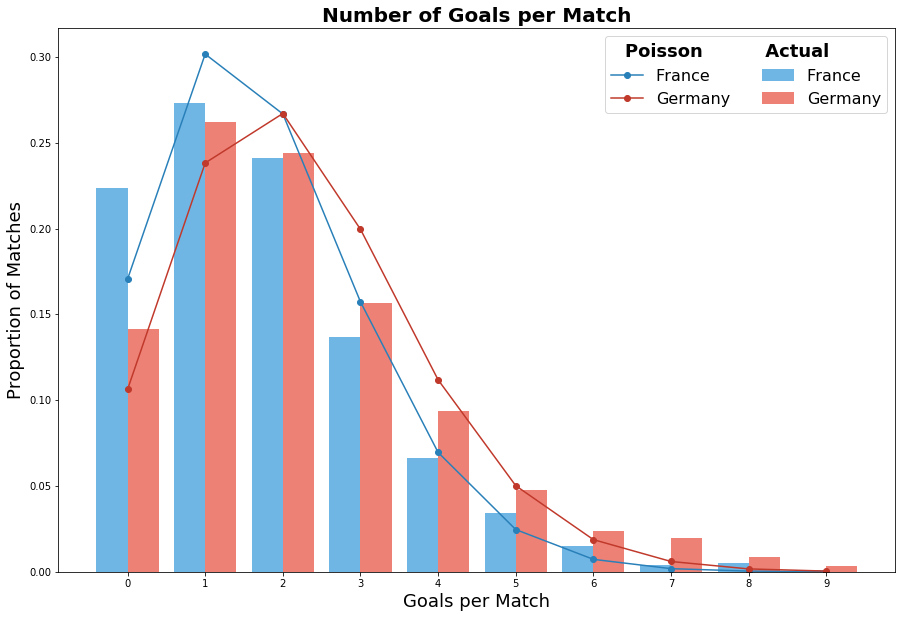

In [37]:
plt.figure(figsize=(15,10))
# plot histogram of actual goals
plt.hist([matches_t1['score'].values, matches_t2['score'].values], range(11), alpha=0.7,
         label=[team1, team2], normed=True, color=["#3498db", "#e74c3c"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t1,
                  linestyle='-', marker='o',label=team1, color = '#2980b9')
pois2, = plt.plot([i-0.5 for i in range(1,11)], poisson_pred_t2,
                  linestyle='-', marker='o',label=team2, color = '#c0392b')

leg=plt.legend(loc='upper right', fontsize=16, ncol=2)
leg.set_title("Poisson          Actual      ", prop = {'size':'18', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,11)],[i for i in range(11)])
plt.xlabel("Goals per Match",size=18)
plt.ylabel("Proportion of Matches",size=18)
plt.title("Number of Goals per Match",size=20,fontweight='bold')
plt.show()

#### Building the model
Now we can agree to say that each team follow the Poisson distribution due to the number of game. So first I will add a weight column that is based on the date of the game because it's obvious that a game that took place this year has more weight than the first game in 1872.

Then I create the data for the model which is composed of 4 columns : team, opponent, goals and weight.

In [40]:
matches.loc[:,'weight'] = 1 / (2019 - matches['date'].dt.year.astype('int64'))

# Create model data
matches_model_data = pd.concat([matches[['home_team','away_team','home_score','weight']].rename(
            columns={'home_team':'team', 'away_team':'opponent','home_score':'goals'}),
           matches[['away_team','home_team','away_score','weight']].rename(
            columns={'away_team':'team', 'home_team':'opponent','away_score':'goals'})])

So here using the statsmodels librairies I create my model with a Poisson regression

In [ ]:
poisson_model = smf.glm(formula="goals ~ team + opponent", data=matches_model_data, 
                        family=sm.families.Poisson(), freq_weights=matches_model_data['weight'].values).fit()

Now it's time to make a function that can return the result of a game, there is some information that we need to know :

The two teams
If the match is a elimination or not (if True we can't return a draw result)
The maximum of draw which will indicate how many draw we will do for the game. The greater this number is, the result will mostly be the result with the greatest probability.
The maximum goals in the game
So first I define the function that will a tuple of two array :

An array with the 3 probabilites of the team 1 to win, a draw game and the team 2 to win.
An array with the probabilities of score for each team

In [ ]:
def get_proba_match(foot_model, team1, team2, max_goals=10):
    # Get the average goal for each team
    t1_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team1, 'opponent': team2}, index=[1])).values[0]
    t2_goals_avg = foot_model.predict(pd.DataFrame(data={'team': team2, 'opponent': team1}, index=[1])).values[0]
    
    # Get probability of all possible score for each team
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [t1_goals_avg, t2_goals_avg]]
    
    # Do the product of the 2 vectors to get the matrix of the match
    match = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    
    # Get the proba for each possible outcome
    t1_wins = np.sum(np.tril(match, -1))
    draw = np.sum(np.diag(match))
    t2_wins = np.sum(np.triu(match, 1))
    result_proba = [t1_wins, draw, t2_wins]
    
    # Adjust the proba to sum to one
    result_proba =  np.array(result_proba)/ np.array(result_proba).sum(axis=0,keepdims=1)
    team_pred[0] = np.array(team_pred[0])/np.array(team_pred[0]).sum(axis=0,keepdims=1)
    team_pred[1] = np.array(team_pred[1])/np.array(team_pred[1]).sum(axis=0,keepdims=1)
    return result_proba, [np.array(team_pred[0]), np.array(team_pred[1])]

In [ ]:
Now I can do the function that will get us the result of the game. It will return the result first (the winner or draw), the looser (it will be 'draw' if it's a draw result) and the score of each team.